In [16]:
import random
from typing import NamedTuple, Union, cast
from functools import cache
from numbers import Integral
from dataclasses import dataclass, field

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

from qiskit_machine_learning.exceptions import QiskitMachineLearningError
from qiskit_ibm_provider import IBMProvider
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
from qiskit.primitives import BackendSampler
from qiskit_aer import AerSimulator
from qiskit_algorithms.gradients import ParamShiftSamplerGradient
from qiskit_algorithms.optimizers import SPSA
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.utils.loss_functions import CrossEntropyLoss

## Generate Data

network_input =  [x, y]
- x: tuple = $[time, displacement]^{n}$
- y: binary = $y \in \{0,1\}^{n}$

where n is the sample size

In [17]:
seed = 144
np.seed = seed

In [18]:
# def get_random_indexes(num):
#     deck = list(range(num))
#     random.shuffle(deck)

#     return sorted([deck.pop() for _ in range(num)])

# result = NamedTuple("Dataset", (('dataset', tuple), ('classes', tuple)))
# def generate_dataset(num_samples, *, random_state = 144, func = lambda x: np.sin(x), noisy_size = 50, detailed = False) -> Union[tuple, result]:
#     np.seed = random_state
    
#     init_x = np.linspace(0, 2 * np.pi, num_samples)
#     rand_indexes = get_random_indexes(noisy_size)
#     noise = np.random.randint(-1000, 1000, (noisy_size, 1)) / 500

#     counter = 0
#     x_0 = []
#     x_1 = []
#     y = []


#     class_a = []
#     class_a_t = []
#     class_b = []
#     class_b_t = []
#     for i, t in enumerate(init_x):
#         if i in rand_indexes:
#             val = noise[counter][0]
#             counter += 1
#             label = 0
#             class_a.append(val)
#             class_a_t.append(t)
#         else:
#             val = func(t)
#             label = 1
#             class_b.append(val)
#             class_b_t.append(t)

#         x_1.append(val)
#         x_0.append(t)
#         y.append(label)

#     if detailed:
        
#         return result((x_0, x_1, y), ((class_a, class_a_t), (class_b, class_b_t)))
#     else:
#         x = np.array(list(zip(x_0, x_1)))
#         return x,y
    


In [19]:
# plt.scatter(cl_at, cl_a, color="r")
# plt.scatter(cl_bt, cl_b, color="b")
# plt.show()

In [20]:

sample_size = 100
f = lambda x: np.sin(x)


# ni = zip(rand_indexes, noise)
init_x = np.linspace(0, 2 * np.pi, sample_size)

deck = list(range(100))
random.shuffle(deck)

rand_indexes = []
for _ in range(50):
    rand_indexes.append(deck.pop())

rand_indexes.sort()
noise = np.random.randint(-1000, 1000, (50, 1)) / 1000

counter = 0
x_0 = []
x_1 = []
y = []


class_a = []
class_a_t = []
class_b = []
class_b_t = []
for i, t in enumerate(init_x):
    if i in rand_indexes:
        val = noise[counter][0]
        counter += 1
        label = 0
        class_a.append(val)
        class_a_t.append(t)
    else:
       val = f(t)
       label = 1
       class_b.append(val)
       class_b_t.append(t)

    x_1.append(val)
    x_0.append(t)
    y.append(label)
    


In [21]:
x = np.array(list(zip(x_0, x_1)))
y = np.array(y)

### Preprocess Data - Normalization

In [22]:
x[:,0] = x[:,0] / (np.max(x[:,0]) - np.min(x[:,0]))
x[:,1] = x[:,1] / (np.max(x[:,1]) - np.min(x[:,1]))



### Visualize Data

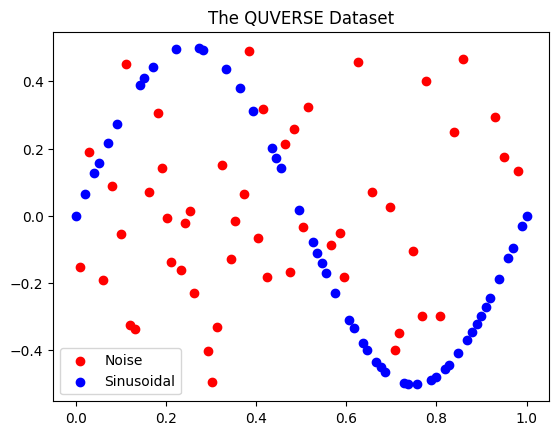

In [23]:
num_classes = 2
num_features = 2
x_red = x[y==0]
x_blue = x[y==1]

plt.scatter(x_red[:,0], x_red[:,1], c='r', label="Noise")
plt.scatter(x_blue[:,0], x_blue[:,1], c='b', label="Sinusoidal")
plt.title("The QUVERSE Dataset")
plt.legend()

### Split Dataset

In [24]:
test_ratio = 0.2
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio, random_state=seed, stratify=y)

print(f"Train set size: {len(x_train)}")
print(f"Test set size:  {len(x_test)}")

Train set size: 80
Test set size:  20


## Data Embedding

### Input

In [25]:
draw_config = {"output": "mpl", "scale": 1.0, "style": "iqp"}

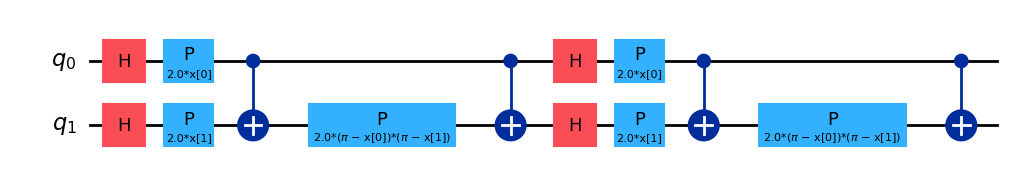

In [26]:
get_zz_feature_map = lambda feature_dim, feature_map_rep, ent: ZZFeatureMap(feature_dimension=feature_dim, reps=feature_map_rep, entanglement=ent)

fmap_zz = get_zz_feature_map(num_features, 2, 'linear')
input_params = fmap_zz.parameters
fmap_zz.decompose().draw(**draw_config)

Assign parameters to feature map

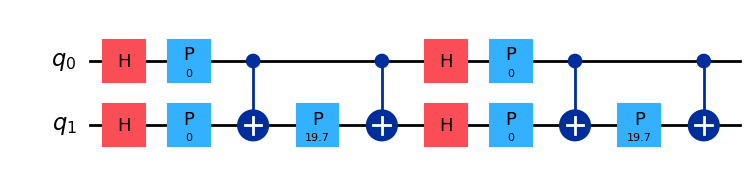

In [27]:
fmap_zz.assign_parameters({k:v for (k,v) in zip(fmap_zz.parameters, x[0])}) \
    .decompose() \
    .draw(**draw_config)

### Ansatz

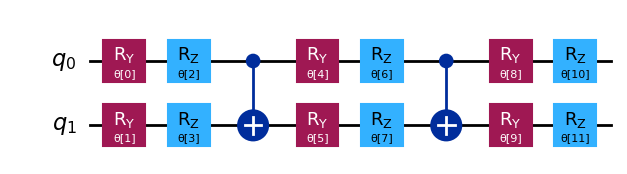

In [28]:
get_two_locals = lambda feature_dim, rotations, var_form_rep, ent: TwoLocal(num_qubits=feature_dim, rotation_blocks=rotations, entanglement_blocks='cx', entanglement=ent, reps=var_form_rep)

ansatz_tl = get_two_locals(num_features, ['ry', 'rz'], 2, 'linear')
weights_params = ansatz_tl.parameters
ansatz_tl.decompose() \
    .draw(**draw_config)

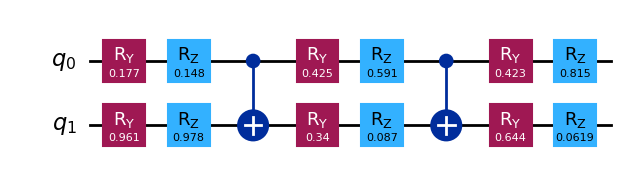

In [29]:
weights = np.random.random(len(ansatz_tl.parameters))
ansatz_tl.assign_parameters({k:v for (k,v) in zip(ansatz_tl.parameters, weights)}) \
    .decompose() \
    .draw(**draw_config)

### Compose Circuit

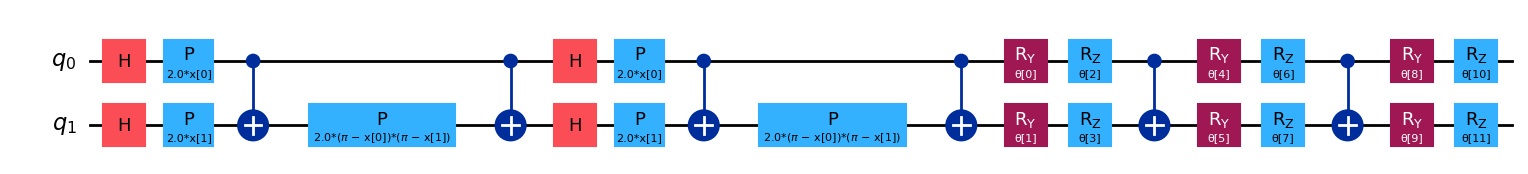

In [30]:
var_circuit = QNNCircuit(feature_map=fmap_zz, ansatz=ansatz_tl)
var_circuit.decompose().draw(**draw_config)

## Define Sampler (Simulator)

In [32]:
options = {}
qasm_sim = AerSimulator()
sampler = BackendSampler(backend=qasm_sim, options=options)

## Define Quantum Neural Network

We will be using the `SamplerQNN`

In [33]:
def one_qubit_binary(x):
    return x % 2

In [34]:
var_circuit_with_meas = var_circuit.copy()
var_circuit_with_meas.measure_all()

In [35]:
paramShiftSampGrad = ParamShiftSamplerGradient(sampler=sampler)

sampler_qnn = SamplerQNN(sampler=sampler,
    circuit=var_circuit_with_meas,
    input_params=input_params,
    weight_params=weights_params,
    interpret=one_qubit_binary,
    output_shape=2,
    gradient=paramShiftSampGrad
)

## Train Classifier

In [36]:
def get_one_hot_encoding(y):
    unique_labels = np.unique(y, axis=0)
    y_one_hot = [(np.eye(len(unique_labels), dtype=int)[np.where(unique_labels == y_i)]).reshape(len(unique_labels)) for y_i in y]

    return np.array(y_one_hot)

y_train_1h = get_one_hot_encoding(y_train)
y_test_1h = get_one_hot_encoding(y_test)

print(f"Label {y_train[2]} converted to {y_train_1h[2]}")
print(f"Label {y_train[0]} converted to {y_train_1h[0]}")

Label 1 converted to [0 1]
Label 0 converted to [1 0]


In [37]:
def spsa_callback(nfev, params, fval, stepsize, accepted=None):
    """
    Can be used for SPSA and GradientDescent optimizers
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    global spsa_loss_recorder

    if (nfev % 3) == 0:
        spsa_loss_recorder.append(fval)

In [38]:
max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=spsa_callback)
spsa_loss_recorder = []
initial_point = np.random.random((len(ansatz_tl.parameters),))
vqc = NeuralNetworkClassifier(neural_network=sampler_qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)

vqc = vqc.fit(x_train, y_train_1h)

Text(0.5, 1.0, 'Training loss')

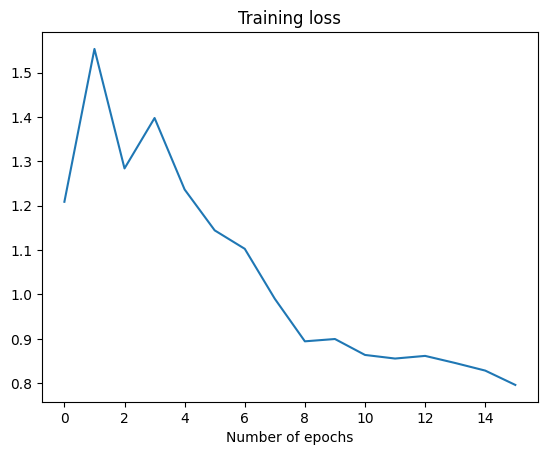

In [39]:
plt.plot(spsa_loss_recorder)
plt.xlabel("Number of epochs")
plt.title("Training loss")

In [40]:
score_train = vqc.score(x_train, y_train_1h)
score_test = vqc.score(x_test, y_test_1h)
print(f'Score on the train set {score_train}')
print(f'Score on the test set {score_test}')

Score on the train set 0.7375
Score on the test set 0.45


In [41]:
y_train_pred = vqc.predict(x_train)

## Make Predictions on Actual Quantum Machine Using Weights from Simulator Training

In [42]:
provider = IBMProvider(instance="pinq-quebec-hub/ecole-dhiver/qml-workshop")

In [ ]:
@dataclass
class Prediction:
    input_data: np.ndarray
    weights: np.ndarray
    output_shape: Integral = 2
    options: dict = field(default_factory=dict)
    backend = provider.get_backend("ibm_quebec")

    def __post_init__(self):
        self.num_samples = self.input_data.shape[0]
        
        self.weights = np.broadcast_to(self.weights, (self.num_samples, len(self.weights)))
        self.parameters = np.concatenate((self.input_data, self.weights), axis = 1)
        self.sampler = BackendSampler(backend=self.backend, options=self.options)

    def run_job(self):
        job = self.sampler.run([var_circuit_with_meas] * self.num_samples, self.parameters)

        try:
            results = job.result()
        except Exception as exc:
            raise QiskitMachineLearningError("Sampler job failed.") from exc
        
        return results
    
    @cache
    def compute_output_shape(self):
        output_shape = int(self.output_shape)
        output_shape_ = (output_shape,)

        return output_shape_
    
    
    def score(self, preds, actual):
        return sum(1 for x, y in zip(preds, actual) if x == y) / len(y_test)
    

    
    def classify(self, results = None) -> tuple[np.ndarray]:
        output_shape = (2,)
        prob = np.zeros((self.num_samples, *output_shape))

        results = self.run_job() if results == None else results
        interpret = lambda x: x % 2

        for i in range(self.num_samples):
            counts = results.quasi_dists[i]

            # evaluate probabilities
            for b, v in counts.items():
                key = interpret(b)

                if isinstance(key, Integral):
                    key = (cast(int, key),)
                    
                key = (i, *key)
                prob[key] += v

        self.preds = np.argmax(prob, axis=1)

        return prob, self.preds
        

In [ ]:
prediction = Prediction(x_test, vqc.weights)
results = prediction.run_job()
test_probs, test_pred = prediction.classify(results)
test_pred_acc = prediction.score(test_pred, y_test)
print(f"Test Accuracy score is {test_pred_acc}")

In [ ]:
y_test_pred = get_one_hot_encoding(test_pred)

In [ ]:
train_pred_acc = np.all(y_train_pred == y_train_1h, axis=1)
test_pred_acc = np.all(y_test_pred == y_test_1h, axis = 1)

In [ ]:
x_all = np.concatenate((x_train, x_test))
y_all = np.concatenate((y_train_1h, y_test_1h))
y_pred_acc_all = np.concatenate((train_pred_acc, test_pred_acc))

x_b = x_all[np.all(y_all == [0, 1], axis=1)]
x_b_good = x_b[(y_pred_acc_all[np.all(y_all == [0, 1], axis=1)])]
x_b_bad = x_b[np.logical_not(y_pred_acc_all[np.all(y_all == [0, 1], axis=1)])]

x_r = x_all[np.all(y_all == [1, 0], axis=1)]
x_r_good = x_r[(y_pred_acc_all[np.all(y_all == [1, 0], axis=1)])]
x_r_bad = x_r[np.logical_not(y_pred_acc_all[np.all(y_all == [1, 0], axis=1)])]

In [ ]:
plt.scatter(x_b_good[:,0], x_b_good[:,1], c='b', marker=".", label="Good Sinusoidal")
plt.scatter(x_b_bad[:,0], x_b_bad[:,1], c='b', marker="x", label="Bad Sinusoidal")
plt.scatter(x_r_good[:,0], x_r_good[:,1], c='r', marker=".", label="Good Noise")
plt.scatter(x_r_bad[:,0], x_r_bad[:,1], c='r', marker="x", label="Bad Noise")

plt.title("QUVERSE dataset classification")
plt.legend()